# シンプルな衝突モデル

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

#==================================================
# 衝突が起きているペアの数を返す関数
# （エージェント間の距離が1未満のペアを衝突とみなす）
#==================================================
def detect_collisions(agent_positions):
    """
    agent_positions: shape = (num_agents, 2)
    距離1未満である衝突ペア(i, j)を返す
    """
    n = len(agent_positions)
    collisions = []
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(agent_positions[i] - agent_positions[j])
            if dist < 1.0:
                collisions.append((i, j))
    return collisions

#==================================================
# シミュレーション関数
#==================================================
def run_simulation(num_agents, num_steps, num_dist, whimsy):
    """
    num_agents: エージェント数
    num_steps : シミュレーションステップ数
    num_dist  : 1ステップでの移動距離

    戻り値:
      positions: shape = (num_steps, num_agents, 2)
                 各ステップ・各エージェントの (x, y) 座標
      collisions_cumulative: shape = (num_steps,)
                 各ステップ時点の累積衝突ペア数
      thetas: shape = (num_steps, num_agents)
                 各ステップ・各エージェントが進んだ角度（ラジアン）
    """
    min_coord, max_coord = -50, 50  # x,yの最小・最大

    # エージェントの初期位置: 範囲内の整数座標にランダム配置
    x_init = np.random.randint(min_coord, max_coord+1, size=num_agents)
    y_init = np.random.randint(min_coord, max_coord+1, size=num_agents)
    
    # 各ステップのエージェント位置を保存する配列(小数型に)
    positions = np.zeros((num_steps, num_agents, 2), dtype=float)
    positions[0, :, 0] = x_init
    positions[0, :, 1] = y_init
    
    # 衝突数(累積)を記録する配列
    collisions_cumulative = np.zeros(num_steps, dtype=int)
    
    # 各ステップでの移動角度を保存する配列
    thetas = np.zeros((num_steps, num_agents), dtype=float)

    # 最初のステップ（t=0）の衝突数を計算
    #collisions_cumulative[0] = detect_collisions(positions[0])
    
    # シミュレーションループ
    for t in range(1, num_steps):
        prev_pos = positions[t-1].copy()
        
        # 0〜360度の現在の向きを保持
        if t == 1:
            # 初期の向きはランダムに設定（0〜360度）
            current_directions = np.random.uniform(0, 360, size=num_agents)
        else:
            # 現在の向きは保存されているものを基準にする
            current_directions = thetas[t-1]

        theta_aligned = current_directions  # ランダム偏差を加えた後の値をコピー
        
        for i in range(num_agents):
            # 自分から半径3以内のエージェント（自分自身は除く）を探す
            neighbors = []
            for j in range(num_agents):
                if i != j:
                    dist_ij = np.linalg.norm(prev_pos[i] - prev_pos[j])
                    if dist_ij < 5.0:
                        neighbors.append(j)
            
            # 半径3以内に他のエージェントがいれば，その向きの平均をとる
            if len(neighbors) > 0:
                # 向きは度数法なので，ベクトル平均してから arctan2 で求める
                sum_cos = np.sum(np.cos(np.deg2rad(theta_aligned[neighbors])))
                sum_sin = np.sum(np.sin(np.deg2rad(theta_aligned[neighbors])))
                avg_angle_deg = np.rad2deg(np.arctan2(sum_sin, sum_cos))
                theta_aligned[i] = avg_angle_deg
            else:
                theta_aligned[i] = theta_aligned[i] + np.random.uniform(-whimsy, whimsy)
        
        # 上書きして確定
        theta = theta_aligned
        theta = theta % 360  # 再度360度範囲に収まるよう調整

        thetas[t] = theta  # 新しい進行方向を保存（度数法）
        
        # ラジアンに変換して計算
        theta_rad = np.deg2rad(theta)  # 度をラジアンに変換
        dx = num_dist * np.cos(theta_rad)
        dy = num_dist * np.sin(theta_rad)


        # 新しい位置
        new_pos = prev_pos + np.column_stack((dx, dy))
        
        # トーラス構造で座標を折り返し
        new_pos[:, 0] = (new_pos[:, 0] - min_coord) % (max_coord - min_coord) + min_coord
        new_pos[:, 1] = (new_pos[:, 1] - min_coord) % (max_coord - min_coord) + min_coord
    
        
        positions[t] = new_pos
        
        # このステップでの衝突数を計算し、累積に足す
        collisions = detect_collisions(new_pos)
        if collisions:
            # 衝突したエージェントの向きをランダムに変更
            collided_agents = set(i for pair in collisions for i in pair)
            new_directions = np.random.uniform(0, 360, size=len(collided_agents))
            collided_agents = list(collided_agents)
            current_directions[collided_agents] = new_directions

            # 新しい向きに沿って0.1だけ進む
            new_directions_rad = np.deg2rad(new_directions)
            positions[t, collided_agents, 0] += 0.1 * np.cos(new_directions_rad)
            positions[t, collided_agents, 1] += 0.1 * np.sin(new_directions_rad)
            
            # トーラス構造で座標を折り返し
            positions[t, collided_agents, 0] = (
                (positions[t, collided_agents, 0] - min_coord) % (max_coord - min_coord) + min_coord
            )
            positions[t, collided_agents, 1] = (
                (positions[t, collided_agents, 1] - min_coord) % (max_coord - min_coord) + min_coord
            )
        
        # 衝突数を累積に足す
        collisions_cumulative[t] = collisions_cumulative[t-1] + len(collisions)
 
    
    return positions, collisions_cumulative, thetas

#==================================================
# アニメーション表示関数
#==================================================
def animate_simulation(positions, collisions_cumulative, thetas, interval=300):
    """
    positions: (num_steps, num_agents, 2)
               各ステップのエージェント座標
    collisions_cumulative: (num_steps,)
               各ステップ時点の累積衝突数
    thetas: (num_steps, num_agents)
               各ステップのエージェントが進んだ方向(ラジアン)
    interval: アニメーション再生速度(フレーム間隔 ms)
    
    戻り値: HTMLオブジェクト (Jupyter/Colab上で動画表示)
    """
    num_steps, num_agents, _ = positions.shape
    
    fig = plt.figure(figsize=(10, 4))
    
    # 左: エージェントの位置(矢印)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlim(-50, 50)
    ax1.set_ylim(-50, 50)
    ax1.set_title("Agent positions (arrows)")
    ax1.set_aspect('equal')
    
    # 初期フレームの描画
    x0 = positions[0, :, 0]
    y0 = positions[0, :, 1]
    theta_rad_0 = np.deg2rad(thetas[0])
    u0 = np.cos(theta_rad_0)  # 矢印の向き(x成分)
    v0 = np.sin(theta_rad_0)  # 矢印の向き(y成分)
    
    # quiverで矢印をまとめて管理
    qv = ax1.quiver(x0, y0, u0, v0, 
                    angles='xy',
                    scale_units='xy',
                    scale=0.3, 
                    width=0.03,
                    headwidth=5,
                    headlength=7,
                    color='blue')
    
    # 右: 累積衝突数の推移
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlim(0, num_steps)
    ax2.set_ylim(0, max(1, collisions_cumulative.max()))
    ax2.set_title("Cumulative Collisions over time")
    line, = ax2.plot([], [], c='blue')
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Cumulative collisions")
    
    def update(frame):
        # frame 番目の座標
        x = positions[frame, :, 0]
        y = positions[frame, :, 1]
        # frame 番目の向き
        theta_rad = np.deg2rad(thetas[frame]) 
        u = np.cos(theta_rad)
        v = np.sin(theta_rad)
        
        # quiverの位置と向きを更新
        # set_offsets() は散布図用なので、quiverは以下の2つで更新する
        qv.set_offsets(np.c_[x, y])   # x,y座標
        qv.set_UVC(u, v)             # ベクトル(u, v)
        
        # 0 ~ frame までの累積衝突数を表示
        line.set_data(np.arange(frame+1), collisions_cumulative[:frame+1])
        
        return qv, line
    
    anim = animation.FuncAnimation(
        fig, update, frames=num_steps, interval=interval, blit=False
    )
    
    # Jupyter/Colab上でアニメーションをHTMLとして表示
    return HTML(anim.to_jshtml())


# シミュレーション実行と結果アニメーションの表示

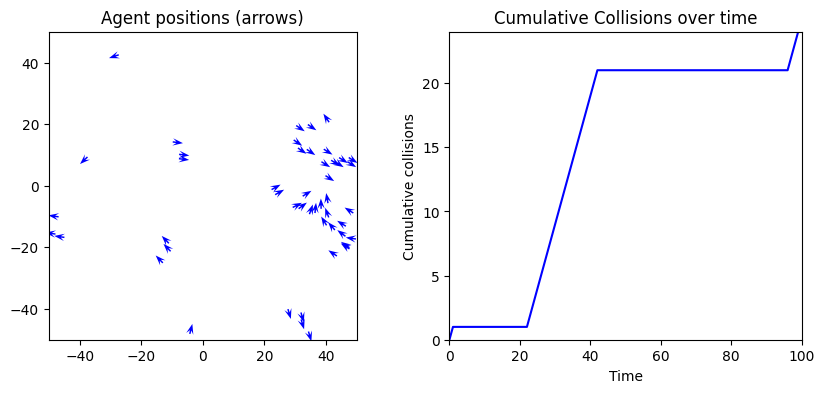

In [2]:
# --- ここを必要に応じて書き換えてください ---
num_agents = 50   # エージェント数
num_steps = 100    # シミュレーションステップ数(エージェントが動く回数)
num_dist = 1    # 移動距離
whimsy = 90    # 頭の向き
speed = 300        # アニメーションの速度(ミリ秒) 例: 300 => 0.3秒間隔

positions, collisions_cumulative, thetas = run_simulation(num_agents, num_steps, num_dist,whimsy)

# アニメーション表示
html_anim = animate_simulation(positions, collisions_cumulative, thetas, interval=300)
html_anim

## テスト